In [32]:
# This project is written by Bin Hoang, University of Rochester, based on the framework the following tutorials in Nov-2021
# This is done using python 3.7, tensorflow 2.3, keras 2.6, cv2
# Parallel Processing using CUDA 10.1 and cuDNN 7.6
# This notebook may not run properly if environment is different

# This project was built on the framework of two tutorials below for SRCNN and autoencoder, respectively
# https://debuggercafe.com/image-super-resolution-using-deep-learning-and-pytorch/ 
# https://keras.io/examples/vision/autoencoder/

# The project combines the work above to create a new pipeline to process noisy and blurry medical images 
# with added utility using structural similarity metrics. Our CNN pipeline combine but autoencoder and SRCNN.

import tensorflow as tf
import keras
from keras import layers
from tensorflow import image 
from keras.models import load_model

import numpy as np
import os
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model

import glob
import cv2
import torch
import torchvision
import torch.optim as optim

from sklearn.model_selection import train_test_split
from skimage import metrics

import sys


In [33]:
#Check if GPU is available for tensorflow
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [34]:
# load images and convert image to np.array from local folder
# 0 if bw image, 1 if color image
def load_images(path,color, sample_size):
    path = glob.glob(path)

    counter = 0
    images = []
    
    for filename in path:
        img = cv2.imread(filename,color)
        img = cv2.resize(img, 
                         dsize=(104, 104), interpolation=cv2.INTER_CUBIC)

        
        if img is not None:
            images.append(img)
        
        counter = counter +1

        if counter > sample_size - 1:
            break
        
        
    images = np.asarray(images,
                        dtype = np.float32)/255.0
    return images

In [35]:
# Add noise given an input image array, noise_level, and noise type. 
# Noise type : 1 = Gaussian, 2= Possion
def add_noise(img, noise_level, noise_type):

    img_size = np.shape(img)
    
    if noise_type == 1:
        noise = np.random.normal(0.0, 1.0, img_size)
    elif noise_type ==2:
        noise = np.random.poisson(1, img_size)
    
    
    img_noise = img+ noise_level*noise
    return img_noise

In [36]:
# Plot images for  viewing
def plot_img(img,n):
    plt.figure(figsize=(20, 4))

    for i in range(n):
    # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(img[i])
        plt.gray()
    
    #disable axis
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [37]:
# Calculate Peak Signal to Noise Ratio, defined as 20*log(MAX/RMSE)
# TAKE NORMALIZED NUMPY ARRAY MATRICES 

def PSNR(target, input_img, dim1, dim2, color):
    
    if color ==1:
        MAX = 255
    else:
        MAX = 1
    
    target = np.reshape(target, (len(target), dim1, dim2, 1))
    input_img = np.reshape(input_img, (len(input_img), dim1, dim2, 1))  

    RMSE = np.sqrt(np.mean(target-input_img)**2)
    
    return 20*np.log10(MAX/RMSE)
    
    
    

In [38]:
def tup2str(tup):
    str = ''
    for i in tup:
        str = str + i
    return str

In [98]:
# Define Structural Simmilarity

def SSIM_loss(true,predict):
          
    SSIM = tf.image.ssim(true, predict, max_val=1, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    SSIM_loss = 1.0-SSIM 
    
    total = SSIM_loss
    
    return SSIM_loss
    #return SSIM_loss


In [40]:
#load_data
train_path_normal = 'C:/Users/bin_h/Dropbox/Classes/Fall2021/Project_AI/My_project_code/source_image/chest_xray/chest_xray/train/NORMAL/*.JPEG'
train_path_pneumonia = 'C:/Users/bin_h/Dropbox/Classes/Fall2021/Project_AI/My_project_code/source_image/chest_xray/chest_xray/train/PNEUMONIA/*.JPG'
test_path_normal = 'C:/Users/bin_h/Dropbox/Classes/Fall2021/Project_AI/My_project_code/source_image/chest_xray/chest_xray/test/NORMAL/*.JPEG'
test_path_pneumonia= 'C:/Users/bin_h/Dropbox/Classes/Fall2021/Project_AI/My_project_code/source_image/chest_xray/chest_xray/test/PNEUMONIA/*.JPEG'

sample_size = 1000

x_train_norm = load_images(train_path_normal,0,sample_size)
x_train_norm = np.clip(x_train_norm,0,1)

x_test_norm = load_images(test_path_normal,0,sample_size)
x_test_norm = np.clip(x_test_norm,0,1)

type(x_train_norm)

numpy.ndarray

In [41]:
# Add noise
noise_scale = 0.1
noise_type = 1 # gaussian noise

x_train_noise = add_noise(x_train_norm, noise_scale, noise_type)
x_train_noise = np.clip(x_train_noise,0,1)

x_test_noise = add_noise(x_test_norm, noise_scale, noise_type)
x_test_noise = np.clip(x_test_noise,0,1)


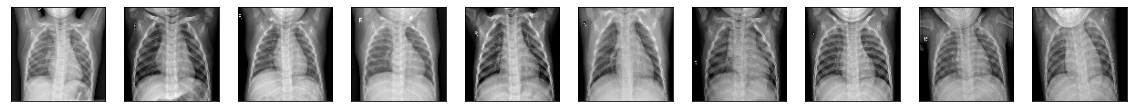

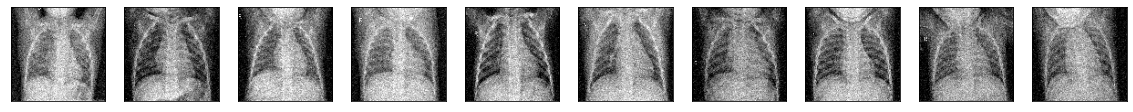

In [42]:
n = 10  # how many records we will display
plot_img(x_train_norm,10)
plot_img(x_train_noise,10)
#plot_img(x_test_noise,10)


In [43]:
# Prep data for training
x_train_flat = np.reshape(x_train_norm, (len(x_train_norm), 104, 104, 1))  
x_train_noise_flat = np.reshape(x_train_noise, (len(x_train_noise), 104, 104, 1))  

x_test_flat = np.reshape(x_test_norm, (len(x_test_norm), 104, 104, 1)) 
x_test_noise_flat = np.reshape(x_test_noise, (len(x_test_noise), 104, 104, 1)) 



In [44]:
def autoencoder_func(input):
        
    print(input.shape)
    x = layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu",padding="same")(input)
    
    x = layers.Conv2D(filters = 32, kernel_size = (2,2), activation="relu",padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    
    x = layers.Conv2D(filters = 32, kernel_size= (3,3), activation="relu",padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    
    x = layers.Conv2DTranspose(filters = 32, kernel_size = (3,3), strides=2, activation="relu",padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2D(filters = 32, kernel_size = (2,2), strides=2, activation="relu",padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)

    
    x = layers.Conv2D(filters = 64, kernel_size = (3,3), strides=2, activation="relu",padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)

    
    # the sigmoid activation function forces the output to be in [0,1] range
    x = layers.Conv2D(filters = 1, kernel_size = (3,3), strides=(1, 1), activation="sigmoid",padding="same")(x)
    
    print(x.shape)
    return x

In [45]:
# Build the autoencoder
img_input = Input(shape=(104, 104, 1)) # Change this if dsize changes in image load

x= autoencoder_func(img_input)
autoencoder = Model(img_input,x)

# Autoencoder
autoencoder.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])  # adam = stochastic gradient descend


(None, 104, 104, 1)
(None, 104, 104, 1)


In [46]:
#x_train_noise_flat.shape
#x_train_flat = np.array(x_train_flat)
#x_train_flat.shape == x_train_noise_flat.shape
x_test_flat.shape == x_test_noise_flat.shape

True

In [47]:
#Fit the model
epoch_auto = 100
fit_log = autoencoder.fit(x_train_noise_flat, #input
                 x_train_flat, #target data
                 epochs = epoch_auto,
                 batch_size = 50, #how many images being trained per cycle, data arrays needs to be a multiple of patch size 
                 shuffle = True,
                 validation_data = (x_test_noise_flat, x_test_flat)) # validation set used to calculate loss

Train on 1000 samples, validate on 234 samples
Epoch 1/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0459 - mean_squared_error: 0.0555 - val_loss: 0.0195 - val_mean_squared_error: 0.0425
Epoch 2/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0105 - mean_squared_error: 0.0331 - val_loss: 0.0064 - val_mean_squared_error: 0.0260
Epoch 3/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0060 - mean_squared_error: 0.0221 - val_loss: 0.0052 - val_mean_squared_error: 0.0191
Epoch 4/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0048 - mean_squared_error: 0.0172 - val_loss: 0.0042 - val_mean_squared_error: 0.0155
Epoch 5/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0044 - mean_squared_error: 0.0143 - val_loss: 0.0039 - val_mean_squared_error: 0.0132
Epoch 6/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0041 - mean_squared_error: 0.0124 - val_loss: 0.0

1000/1000 [==============================] - 1s 1ms/step - loss: 0.0026 - mean_squared_error: 0.0039 - val_loss: 0.0022 - val_mean_squared_error: 0.0039
Epoch 51/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0039 - val_loss: 0.0022 - val_mean_squared_error: 0.0039
Epoch 52/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0039 - val_loss: 0.0022 - val_mean_squared_error: 0.0038
Epoch 53/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0038 - val_loss: 0.0023 - val_mean_squared_error: 0.0038
Epoch 54/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0038 - val_loss: 0.0022 - val_mean_squared_error: 0.0038
Epoch 55/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0038 - val_loss: 0.0022 - val_mean_squared_error: 0.0038
Epoch 56/100
1000

1000/1000 [==============================] - 1s 1ms/step - loss: 0.0022 - mean_squared_error: 0.0031 - val_loss: 0.0021 - val_mean_squared_error: 0.0031
Epoch 100/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0022 - mean_squared_error: 0.0031 - val_loss: 0.0020 - val_mean_squared_error: 0.0031


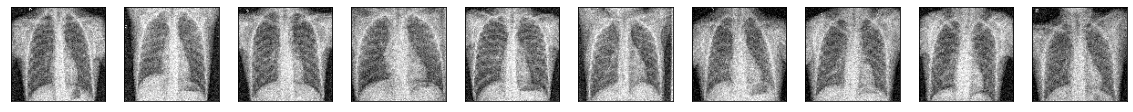

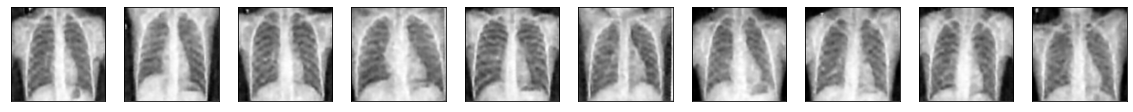

In [48]:
# Predict model 
x_denoise = autoencoder.predict(x_test_noise_flat)

plot_img(x_test_noise,10)
plot_img(x_denoise,10)

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


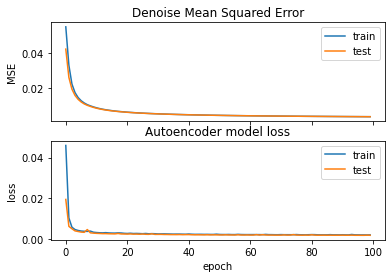

In [49]:
# list all data in history
print(fit_log.history.keys())

fig, axs = plt.subplots(2, sharex=True)

#fig.suptitle('Train history')

axs[0].plot(fit_log.history['mean_squared_error'])
axs[0].plot(fit_log.history['val_mean_squared_error'])

axs[0].set_title('Denoise Mean Squared Error')
axs[0].set_ylabel('MSE')
#axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'test'], loc='upper right')

# summarize history for loss
axs[1].plot(fit_log.history['loss'])
axs[1].plot(fit_log.history['val_loss'])

axs[1].set_title('Autoencoder model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'test'], loc='upper right')

loss_mode = 1 # MSE only for autoconder
if loss_mode == 1:
    if noise_scale <= 0.1:
        filename = f"data{sample_size}", f"epoch{epoch_auto}", f"lightnoise",f"_denoise_MSE",f".jpeg"
    elif 0.1 <noise_scale < 0.5:
        filename = f"data{sample_size}", f"epoch{epoch_auto}", f"mediumnoise",f"_denoise_MSE",f".jpeg"
    else:
        filename = f"data{sample_size}", f"epoch{epoch_auto}", f"heavynoise",f"_denoise_MSE",f".jpeg"
else:
    if noise_scale <= 0.1:
        filename = f"data{sample_size}", f"epoch{epoch_autoN}", f"lightnoise",f"_denoise_SSIM",f".jpeg"
    elif 0.1 < noise_scale < 0.5:
        filename = f"data{sample_size}", f"epoch{epoch_autoauto}", f"mediumnoise",f"_denoise_SSIM",f".jpeg"
    else : 
        filename = f"data{sample_size}", f"epoch{epoch_auto}", f"heavynoise",f"_denoise_SSIM",f".jpeg"
        
filename_str_blur = tup2str(filename) 
#print(filename_str_blur)
plt.savefig(filename_str_blur,  dpi=300)



In [50]:
# Build SRCNN neural network

def SRCNN(input):
        
    print(input.shape)
    x = layers.Conv2D(filters = 128, kernel_size = (9,9), activation="relu",padding="same")(input)
    
    x = layers.Conv2D(filters = 64, kernel_size = (1,1), activation="relu",padding="same")(x)
       
    # the linear activation (all the layers of the output collapses into one)
    x = layers.Conv2D(filters = 1, kernel_size = (5,5), strides=(1, 1), activation="linear",padding="same")(x)
    
    print(x.shape)
    return x


In [99]:
# Compile SRCNN
x_SRCNN = SRCNN(img_input)

# SRCNN
SRCNN_model = Model(img_input, x_SRCNN)


# Load model into Keras
#filepath = C:/Users/bin_h/Dropbox/Classes/Fall2021/Project_AI/My_project_code/
#model = load_model('filepath', custom_objects={'SSIM_loss':SSIM_loss}) load model to graph SSMI

loss_mode = 0

if loss_mode == 2:
    SRCNN_model.compile(optimizer='adamax', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])  # adam = stochastic gradient descend
else:
    SRCNN_model.compile(optimizer='adamax', loss= SSIM_loss, metrics=[tf.keras.metrics.MeanSquaredError()])  # adam = stochastic gradient descend


(None, 104, 104, 1)
(None, 104, 104, 1)


In [100]:
# Split the denoise images into test and train sujbects
(xblur_train, xblur_target, y_train, y_target) = train_test_split(x_denoise, x_test_flat, test_size=0.2)

print(f"Train data instances: {len(xblur_train)}")

print(f"Validation data instances: {len(xblur_target)}")


Train data instances: 187
Validation data instances: 47


In [101]:
# Train the model
epoch_SRCNN = 500

fit_log_deblur = SRCNN_model.fit(xblur_train, #input
                 y_train, #target data
                 epochs = epoch_SRCNN,
                 batch_size = 50, #how many images being trained per cycle, data arrays needs to be a multiple of patch size 
                 shuffle = True,
                 validation_data = (xblur_target, y_target)) # validation set used to calculate loss

Train on 187 samples, validate on 47 samples
Epoch 1/500
187/187 [==============================] - 1s 4ms/step - loss: 0.6604 - mean_squared_error: 0.1873 - val_loss: 0.5272 - val_mean_squared_error: 0.1584
Epoch 2/500
187/187 [==============================] - 0s 866us/step - loss: 0.4464 - mean_squared_error: 0.1551 - val_loss: 0.3637 - val_mean_squared_error: 0.1246
Epoch 3/500
187/187 [==============================] - 0s 850us/step - loss: 0.3304 - mean_squared_error: 0.1024 - val_loss: 0.2889 - val_mean_squared_error: 0.0874
Epoch 4/500
187/187 [==============================] - 0s 853us/step - loss: 0.2772 - mean_squared_error: 0.0772 - val_loss: 0.2530 - val_mean_squared_error: 0.0690
Epoch 5/500
187/187 [==============================] - 0s 853us/step - loss: 0.2533 - mean_squared_error: 0.0620 - val_loss: 0.2419 - val_mean_squared_error: 0.0566
Epoch 6/500
187/187 [==============================] - 0s 845us/step - loss: 0.2445 - mean_squared_error: 0.0523 - val_loss: 0.2364 

187/187 [==============================] - 0s 848us/step - loss: 0.2114 - mean_squared_error: 0.0096 - val_loss: 0.2109 - val_mean_squared_error: 0.0095
Epoch 51/500
187/187 [==============================] - 0s 850us/step - loss: 0.2113 - mean_squared_error: 0.0094 - val_loss: 0.2110 - val_mean_squared_error: 0.0094
Epoch 52/500
187/187 [==============================] - 0s 874us/step - loss: 0.2111 - mean_squared_error: 0.0093 - val_loss: 0.2108 - val_mean_squared_error: 0.0093
Epoch 53/500
187/187 [==============================] - 0s 864us/step - loss: 0.2110 - mean_squared_error: 0.0092 - val_loss: 0.2107 - val_mean_squared_error: 0.0092
Epoch 54/500
187/187 [==============================] - 0s 848us/step - loss: 0.2109 - mean_squared_error: 0.0091 - val_loss: 0.2104 - val_mean_squared_error: 0.0091
Epoch 55/500
187/187 [==============================] - 0s 856us/step - loss: 0.2108 - mean_squared_error: 0.0090 - val_loss: 0.2104 - val_mean_squared_error: 0.0090
Epoch 56/500
187/

187/187 [==============================] - 0s 834us/step - loss: 0.2078 - mean_squared_error: 0.0064 - val_loss: 0.2076 - val_mean_squared_error: 0.0064
Epoch 100/500
187/187 [==============================] - 0s 837us/step - loss: 0.2078 - mean_squared_error: 0.0064 - val_loss: 0.2078 - val_mean_squared_error: 0.0063
Epoch 101/500
187/187 [==============================] - 0s 837us/step - loss: 0.2080 - mean_squared_error: 0.0063 - val_loss: 0.2074 - val_mean_squared_error: 0.0063
Epoch 102/500
187/187 [==============================] - 0s 861us/step - loss: 0.2079 - mean_squared_error: 0.0063 - val_loss: 0.2076 - val_mean_squared_error: 0.0063
Epoch 103/500
187/187 [==============================] - 0s 853us/step - loss: 0.2077 - mean_squared_error: 0.0063 - val_loss: 0.2075 - val_mean_squared_error: 0.0062
Epoch 104/500
187/187 [==============================] - 0s 853us/step - loss: 0.2076 - mean_squared_error: 0.0062 - val_loss: 0.2075 - val_mean_squared_error: 0.0062
Epoch 105/50

187/187 [==============================] - 0s 858us/step - loss: 0.2057 - mean_squared_error: 0.0052 - val_loss: 0.2053 - val_mean_squared_error: 0.0052
Epoch 149/500
187/187 [==============================] - 0s 848us/step - loss: 0.2055 - mean_squared_error: 0.0052 - val_loss: 0.2056 - val_mean_squared_error: 0.0052
Epoch 150/500
187/187 [==============================] - 0s 853us/step - loss: 0.2054 - mean_squared_error: 0.0052 - val_loss: 0.2051 - val_mean_squared_error: 0.0052
Epoch 151/500
187/187 [==============================] - 0s 850us/step - loss: 0.2053 - mean_squared_error: 0.0052 - val_loss: 0.2060 - val_mean_squared_error: 0.0052
Epoch 152/500
187/187 [==============================] - 0s 848us/step - loss: 0.2059 - mean_squared_error: 0.0052 - val_loss: 0.2055 - val_mean_squared_error: 0.0051
Epoch 153/500
187/187 [==============================] - 0s 853us/step - loss: 0.2053 - mean_squared_error: 0.0051 - val_loss: 0.2050 - val_mean_squared_error: 0.0051
Epoch 154/50

187/187 [==============================] - 0s 880us/step - loss: 0.2038 - mean_squared_error: 0.0046 - val_loss: 0.2036 - val_mean_squared_error: 0.0046
Epoch 198/500
187/187 [==============================] - 0s 885us/step - loss: 0.2038 - mean_squared_error: 0.0046 - val_loss: 0.2041 - val_mean_squared_error: 0.0046
Epoch 199/500
187/187 [==============================] - 0s 883us/step - loss: 0.2037 - mean_squared_error: 0.0046 - val_loss: 0.2040 - val_mean_squared_error: 0.0046
Epoch 200/500
187/187 [==============================] - 0s 885us/step - loss: 0.2038 - mean_squared_error: 0.0046 - val_loss: 0.2036 - val_mean_squared_error: 0.0046
Epoch 201/500
187/187 [==============================] - 0s 869us/step - loss: 0.2034 - mean_squared_error: 0.0046 - val_loss: 0.2037 - val_mean_squared_error: 0.0046
Epoch 202/500
187/187 [==============================] - 0s 877us/step - loss: 0.2036 - mean_squared_error: 0.0046 - val_loss: 0.2041 - val_mean_squared_error: 0.0046
Epoch 203/50

187/187 [==============================] - 0s 856us/step - loss: 0.2022 - mean_squared_error: 0.0042 - val_loss: 0.2023 - val_mean_squared_error: 0.0042
Epoch 247/500
187/187 [==============================] - ETA: 0s - loss: 0.2032 - mean_squared_error: 0.00 - 0s 856us/step - loss: 0.2026 - mean_squared_error: 0.0042 - val_loss: 0.2034 - val_mean_squared_error: 0.0042
Epoch 248/500
187/187 [==============================] - 0s 853us/step - loss: 0.2027 - mean_squared_error: 0.0042 - val_loss: 0.2021 - val_mean_squared_error: 0.0042
Epoch 249/500
187/187 [==============================] - 0s 869us/step - loss: 0.2023 - mean_squared_error: 0.0042 - val_loss: 0.2025 - val_mean_squared_error: 0.0042
Epoch 250/500
187/187 [==============================] - 0s 853us/step - loss: 0.2024 - mean_squared_error: 0.0042 - val_loss: 0.2033 - val_mean_squared_error: 0.0042
Epoch 251/500
187/187 [==============================] - 0s 850us/step - loss: 0.2028 - mean_squared_error: 0.0042 - val_loss: 

Epoch 295/500
187/187 [==============================] - 0s 848us/step - loss: 0.2015 - mean_squared_error: 0.0040 - val_loss: 0.2019 - val_mean_squared_error: 0.0040
Epoch 296/500
187/187 [==============================] - 0s 853us/step - loss: 0.2016 - mean_squared_error: 0.0040 - val_loss: 0.2016 - val_mean_squared_error: 0.0040
Epoch 297/500
187/187 [==============================] - 0s 848us/step - loss: 0.2013 - mean_squared_error: 0.0040 - val_loss: 0.2018 - val_mean_squared_error: 0.0040
Epoch 298/500
187/187 [==============================] - 0s 856us/step - loss: 0.2012 - mean_squared_error: 0.0039 - val_loss: 0.2015 - val_mean_squared_error: 0.0039
Epoch 299/500
187/187 [==============================] - 0s 853us/step - loss: 0.2011 - mean_squared_error: 0.0039 - val_loss: 0.2012 - val_mean_squared_error: 0.0039
Epoch 300/500
187/187 [==============================] - 0s 850us/step - loss: 0.2008 - mean_squared_error: 0.0039 - val_loss: 0.2013 - val_mean_squared_error: 0.003

Epoch 344/500
187/187 [==============================] - 0s 850us/step - loss: 0.2004 - mean_squared_error: 0.0038 - val_loss: 0.2008 - val_mean_squared_error: 0.0038
Epoch 345/500
187/187 [==============================] - 0s 853us/step - loss: 0.2002 - mean_squared_error: 0.0038 - val_loss: 0.2004 - val_mean_squared_error: 0.0038
Epoch 346/500
187/187 [==============================] - ETA: 0s - loss: 0.1998 - mean_squared_error: 0.00 - 0s 848us/step - loss: 0.2000 - mean_squared_error: 0.0038 - val_loss: 0.2010 - val_mean_squared_error: 0.0038
Epoch 347/500
187/187 [==============================] - 0s 853us/step - loss: 0.1998 - mean_squared_error: 0.0038 - val_loss: 0.2005 - val_mean_squared_error: 0.0038
Epoch 348/500
187/187 [==============================] - 0s 848us/step - loss: 0.1998 - mean_squared_error: 0.0038 - val_loss: 0.2004 - val_mean_squared_error: 0.0038
Epoch 349/500
187/187 [==============================] - 0s 842us/step - loss: 0.1999 - mean_squared_error: 0.003

Epoch 393/500
187/187 [==============================] - 0s 848us/step - loss: 0.1993 - mean_squared_error: 0.0036 - val_loss: 0.2002 - val_mean_squared_error: 0.0036
Epoch 394/500
187/187 [==============================] - 0s 861us/step - loss: 0.1994 - mean_squared_error: 0.0036 - val_loss: 0.2002 - val_mean_squared_error: 0.0036
Epoch 395/500
187/187 [==============================] - 0s 853us/step - loss: 0.1994 - mean_squared_error: 0.0036 - val_loss: 0.2006 - val_mean_squared_error: 0.0036
Epoch 396/500
187/187 [==============================] - 0s 842us/step - loss: 0.1996 - mean_squared_error: 0.0036 - val_loss: 0.2002 - val_mean_squared_error: 0.0036
Epoch 397/500
187/187 [==============================] - 0s 856us/step - loss: 0.1994 - mean_squared_error: 0.0036 - val_loss: 0.2002 - val_mean_squared_error: 0.0036
Epoch 398/500
187/187 [==============================] - 0s 861us/step - loss: 0.1991 - mean_squared_error: 0.0036 - val_loss: 0.1998 - val_mean_squared_error: 0.003

Epoch 442/500
187/187 [==============================] - 0s 858us/step - loss: 0.1984 - mean_squared_error: 0.0035 - val_loss: 0.1988 - val_mean_squared_error: 0.0035
Epoch 443/500
187/187 [==============================] - 0s 853us/step - loss: 0.1980 - mean_squared_error: 0.0035 - val_loss: 0.1986 - val_mean_squared_error: 0.0035
Epoch 444/500
187/187 [==============================] - 0s 858us/step - loss: 0.1978 - mean_squared_error: 0.0035 - val_loss: 0.1990 - val_mean_squared_error: 0.0035
Epoch 445/500
187/187 [==============================] - 0s 845us/step - loss: 0.1980 - mean_squared_error: 0.0035 - val_loss: 0.1990 - val_mean_squared_error: 0.0035
Epoch 446/500
187/187 [==============================] - 0s 842us/step - loss: 0.1980 - mean_squared_error: 0.0035 - val_loss: 0.1986 - val_mean_squared_error: 0.0035
Epoch 447/500
187/187 [==============================] - 0s 837us/step - loss: 0.1978 - mean_squared_error: 0.0035 - val_loss: 0.1992 - val_mean_squared_error: 0.003

187/187 [==============================] - 0s 874us/step - loss: 0.1976 - mean_squared_error: 0.0034 - val_loss: 0.1987 - val_mean_squared_error: 0.0034
Epoch 492/500
187/187 [==============================] - 0s 858us/step - loss: 0.1976 - mean_squared_error: 0.0034 - val_loss: 0.1988 - val_mean_squared_error: 0.0034
Epoch 493/500
187/187 [==============================] - 0s 845us/step - loss: 0.1978 - mean_squared_error: 0.0034 - val_loss: 0.1994 - val_mean_squared_error: 0.0034
Epoch 494/500
187/187 [==============================] - 0s 845us/step - loss: 0.1980 - mean_squared_error: 0.0034 - val_loss: 0.1987 - val_mean_squared_error: 0.0034
Epoch 495/500
187/187 [==============================] - 0s 842us/step - loss: 0.1978 - mean_squared_error: 0.0034 - val_loss: 0.1989 - val_mean_squared_error: 0.0034
Epoch 496/500
187/187 [==============================] - 0s 850us/step - loss: 0.1977 - mean_squared_error: 0.0034 - val_loss: 0.1983 - val_mean_squared_error: 0.0034
Epoch 497/50

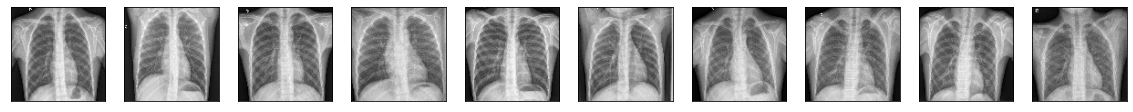

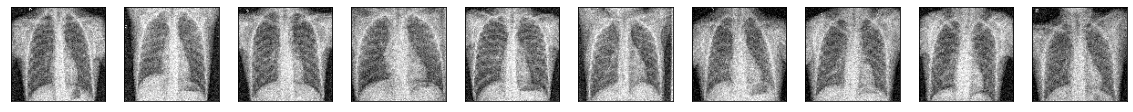

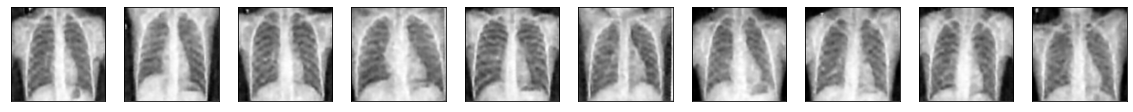

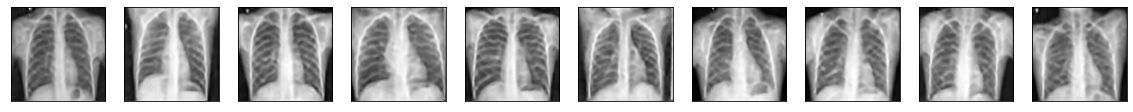

In [102]:
# Predict model 
x_deblur= SRCNN_model.predict(x_denoise)
x_deblur2= SRCNN_model.predict(x_test_flat)


plot_img(x_test_norm,10)
plot_img(x_test_noise,10)

plot_img(x_denoise,10)
plot_img(x_deblur,10)
#plot_img(x_deblur2,10)

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])
data1000epoch500lightnoise_deblur_SSIM.jpeg


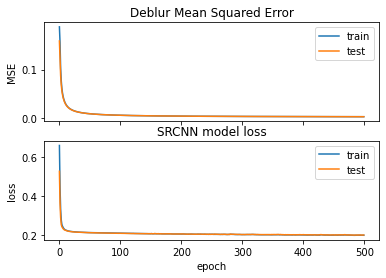

In [103]:
# list all data in history
print(fit_log_deblur.history.keys())

fig, axs = plt.subplots(2, sharex=True)

#fig.suptitle('Train history')

axs[0].plot(fit_log_deblur.history['mean_squared_error'])
axs[0].plot(fit_log_deblur.history['val_mean_squared_error'])

axs[0].set_title('Deblur Mean Squared Error')
axs[0].set_ylabel('MSE')
#axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'test'], loc='upper right')

# summarize history for loss
axs[1].plot(fit_log_deblur.history['loss'])
axs[1].plot(fit_log_deblur.history['val_loss'])

axs[1].set_title('SRCNN model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'test'], loc='upper right')

if loss_mode == 1:
    if noise_scale <= 0.1:
        filename = f"data{sample_size}", f"epoch{epoch_SRCNN}", f"lightnoise",f"_deblur_MSE",f".jpeg"
    elif 0.1< noise_scale < 0.5:
        filename = f"data{sample_size}", f"epoch{epoch_SRCNN}", f"mediumnoise",f"_deblur_MSE",f".jpeg"
    else: 
        filename = f"data{sample_size}", f"epoch{epoch_SRCNN}", f"heavynoise",f"_deblur_MSE",f".jpeg"
else:
    if noise_scale <= 0.1:
        filename = f"data{sample_size}", f"epoch{epoch_SRCNN}", f"lightnoise",f"_deblur_SSIM",f".jpeg"
    elif 0.1< noise_scale < 0.5:
        filename = f"data{sample_size}", f"epoch{epoch_SRCNN}", f"mediumnoise",f"_deblur_SSIM",f".jpeg"
    else : 
        filename = f"data{sample_size}", f"epoch{epoch_SRCNN}", f"heavynoise",f"_deblur_SSIM",f".jpeg"
filename_str_blur = tup2str(filename) 
print(filename_str_blur)
plt.savefig(filename_str_blur,  dpi=300)


In [110]:
# Comparison Matrices
# Calculate PSNR:
if loss_mode == 1:
    filename = f"data{sample_size}", f"epoch{epoch_SRCNN}", f"noise_scale{noise_scale}",f"_deblur_MSE"
else:
    filename = f"data{sample_size}", f"epoch{epoch_SRCNN}", f"noise_scale{noise_scale}",f"_deblur_SSIM"

filename_str = tup2str(filename)

fp = open(filename_str + '.txt', "a")
print(f"\ndata={sample_size}", f"epoch:{epoch_SRCNN}", f"noise_scale:{noise_scale}", file=fp)

#  PSNR(target, input_img, dim1, dim2, color):
PSNR_Auto2SRCNN = PSNR(x_deblur[:,:,:,0], x_denoise[:,:,:,0], 104, 104, 0)
print(f"PSNR_Auto:{PSNR_Auto} ",file= fp)

#PSNR_SRCNN = PSNR(x_test_norm, x_deblur[:,:,:,0], 104, 104, 0)
#print(f"PSNR_SRCNN:{PSNR_SRCNN} ",file= fp)

# MSE
mse_noise = np.sqrt(np.mean(x_test_norm-x_denoise[:,:,:,0])**2)
print(f"MSE_noise:{mse_noise} ",file= fp)

mse_blur = np.sqrt(np.mean(x_test_norm-x_deblur[:,:,:,0])**2)
print(f"MSE_blur:{mse_blur} ",file= fp)

# SSIM: structure similarity defined by University of Waterloo, https://en.wikipedia.org/wiki/Structural_similarity
SSIM_noise = metrics.structural_similarity(x_test_norm,x_denoise[:,:,:,0])
print(f"SSIM_noise:{SSIM_noise} ",file= fp)

SSIM_blur = metrics.structural_similarity(x_test_norm, x_deblur[:,:,:,0])
print(f"SSIM_blur:{SSIM_blur} ",file= fp)

fp.close()

#print everything out
print(f"\ndata={sample_size}", f"epoch:{epoch_SRCNN}", f"noise_scale:{noise_scale}")
print(f"PSNR_Auto2SRCNN:{PSNR_Auto2SRCNN} ")
print(f"PSNR_SRCNN2Original:{PSNR_SRCNN} ")
print(f"MSE_noise:{mse_noise} ")
print(f"MSE_blur:{mse_blur} ")
print(f"SSIM_noise:{SSIM_noise} ")
print(f"SSIM_blur:{SSIM_blur} ")




data=1000 epoch:500 noise_scale:0.1
PSNR_Auto2SRCNN:39.177260327854746 
PSNR_SRCNN2Original:36.502915675791826 
MSE_noise:0.003963823895901442 
MSE_blur:0.014957334846258163 
SSIM_noise:0.9354888281040907 
SSIM_blur:0.9379745162928892 
